# K-Nearest Neighbors (Classification)

This notebook implements the custom k-nearest neighbors (KNN) classification algorithm on the Palmer Penguins dataset. Here, KNN is used to classify penguins by species based on input data for various numerical features, including bill length, bill width, flipper length, and body mass. The objective of this task is to validate the use of the custom KNN classifier, and evaluate its performance for a multi-class and multi-feature classification problem.

The following sections are included in this notebook:
1. **Library Imports**
- Importing the necessary modules, packages, and libraries
- Specifies dependencies and preferred versions
2. **Data Loading and Cleaning**
- Loads the Palmer Penguins dataset with relevant features
- Drops outliers, duplicates, and missing data
- Creates arrays for the features and target variable
3. **Data Visualization**
- Visualizes the correlation between features using a heatmap
- Visualizes the distribution of two features with the target on a 2D color plot
4. **KNN Implementation (2 Features)**
- Implements the custom-built KNN classification algorithm with two input features  
- Visualizes the classification  
- Evaluates the results across multiple metrics  
5. **KNN Implementation (Changing Parameters)**
- Implements the custom-built KNN classification algorithm with various parameters (*k*, distance metrics)
- Examines the effect on model performance
6. **KNN Implementation (Multiple Features)**
- Implements the custom-built KNN classification algorithm with more than two features to ensure functionality
- Evaluates the results across multiple metrics
7. **Comparison with Existing Models**
- Runs the scikit-learn version of KNN
- Compares the results with the custom-built class to verify the latter

*For a more comprehensive overview of the KNN classification algorithm, code structure, and metrics used, see the associated [README](README.md).*

### Library Imports
This section imports the packages and modules required to run the KNN algorithm. The following dependencies (with recommended versions) are required:
- Python 3.9.6
- Numpy 1.26.4
- Pandas 2.3.3
- Matplotlib 3.9.4
- Seaborn 0.13.2
- Sklearn 1.6.1

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.supervised_learning.knn import *
from rice_ml.postprocess.classificationpost import *

### Data Loading & Cleaning
*Loading, preprocessing, and dividing data*

The data used in this notebook comes from Palmer Penguins, a common toy dataset for evaluating classification algorithms. It has been selected for its simplicity and clear feature relationships, and because it requires several data cleaning steps that showcase the `rice_ml` preprocessing modules, including handling missing values. The features of interest in this example are *species* (categorical and the target variable for classification), *bill length* (numeric), *bill depth* (numeric), *flipper length* (numeric), and *body mass* (numeric). 

The data is first loaded as a Pandas DataFrame. For classification, the *species* feature is converted into discrete integer values from 0 to 2, each representing a separate species.

In [27]:
# Loading the basic dataset and selecting features
penguins_df = sns.load_dataset("penguins")
penguin_features = penguins_df[[
    "species", 
    "bill_length_mm", 
    "bill_depth_mm", 
    "flipper_length_mm", 
    "body_mass_g"
]]
 
# Encoding the target as a numeric feature
penguin_features.loc[:, 'species'], uniques = pd.factorize(penguin_features['species'])

display(penguin_features)

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,0,39.1,18.7,181.0,3750.0
1,0,39.5,17.4,186.0,3800.0
2,0,40.3,18.0,195.0,3250.0
3,0,NaN,NaN,NaN,NaN
4,0,36.7,19.3,193.0,3450.0
...,...,...,...,...,...
339,2,NaN,NaN,NaN,NaN
340,2,46.8,14.3,215.0,4850.0
341,2,50.4,15.7,222.0,5750.0
342,2,45.2,14.8,212.0,5200.0


The dataset contains some missing or NaN values (e.g., row 4) and may contain outlier or duplicate rows that will skew the results of the classification. To clean the data, we apply a series of preprocessing steps from the `rice_ml` preprocessing package, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another.

In [28]:
# Cleaning the dataset (dropping rows with missing values, duplicates, or containing outliers)
penguin_features_cleaned_missing = missing_data(penguin_features, 'drop')
penguin_features_cleaned_outliers = outlier_identify(penguin_features_cleaned_missing, 'zscore', drop = True)
penguin_features_cleaned = duplicate_identify(penguin_features_cleaned_outliers, True)
print(f"Cleaned data (first five rows): \n {penguin_features_cleaned[0:5, :]}")

Cleaned data (first five rows): 
 [[   0.    39.1   18.7  181.  3750. ]
 [   0.    39.5   17.4  186.  3800. ]
 [   0.    40.3   18.   195.  3250. ]
 [   0.    36.7   19.3  193.  3450. ]
 [   0.    39.3   20.6  190.  3650. ]]


Two rows have been removed during cleaning, and the dataset no longer contains NaN values. For use in KNN classification and for ease of visualization, the dataset must be split into the target (*species*) and the remaining features.

In [29]:
# Creating two arrays for target and other features
penguin_species = penguin_features_cleaned[:, 0]
penguin_feature_data = penguin_features_cleaned[:, 1:]
print(f"Array for penguin species (first five entries): \n {penguin_species[0:5]} \n \n \
Array for penguin feature data (first five rows): \n {penguin_feature_data[0:5]}")

Array for penguin species (first five entries): 
 [0. 0. 0. 0. 0.] 
 
 Array for penguin feature data (first five rows): 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


### Data Visualization
*Correlations and feature plotting*

Once the data has been appropriately cleaned, the relationships between variables can be visualized using a set of methods. We first visualize the correlations between features using a heatmap of a calculated correlation matrix, applied to the cleaned DataFrame that includes all relevant features. Doing so allows for the identification of features that are correlated with the target, and may thus be appropriate for classification using KNN.

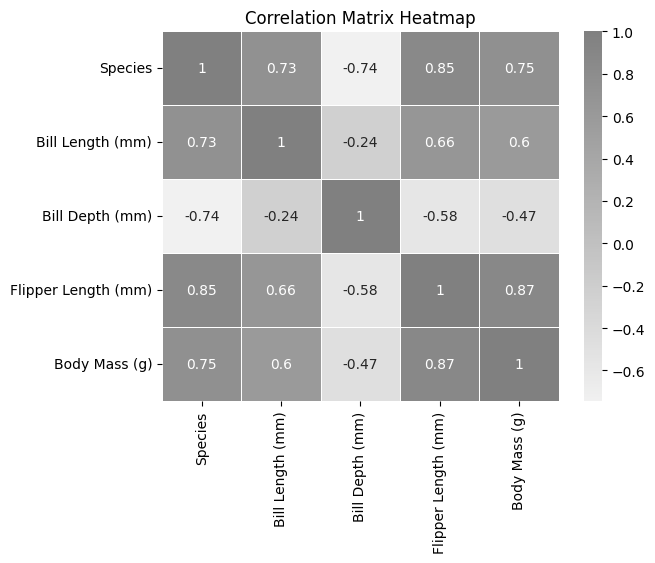

In [30]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(penguin_features_cleaned, columns = ['Species', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'])).corr()
sns.heatmap(correlation_matrix, annot = True, cmap = sns.light_palette('gray', as_cmap=True), linewidths = 0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Both bill length and bill depth appear to be correlated with species (0.73 and -0.74, respectively), while they are not highly correlated with one another. Consequently, these variables are appropriate for a two-variable KNN, and we will select these as the features for predicting species. To visualize the relationship between the three variables (*bill length*, *bill depth*, and *species*) and identify possible clusters prior to formal analysis, we can create a two-dimensional plot of bill depth versus bill length, with colors indicating species.

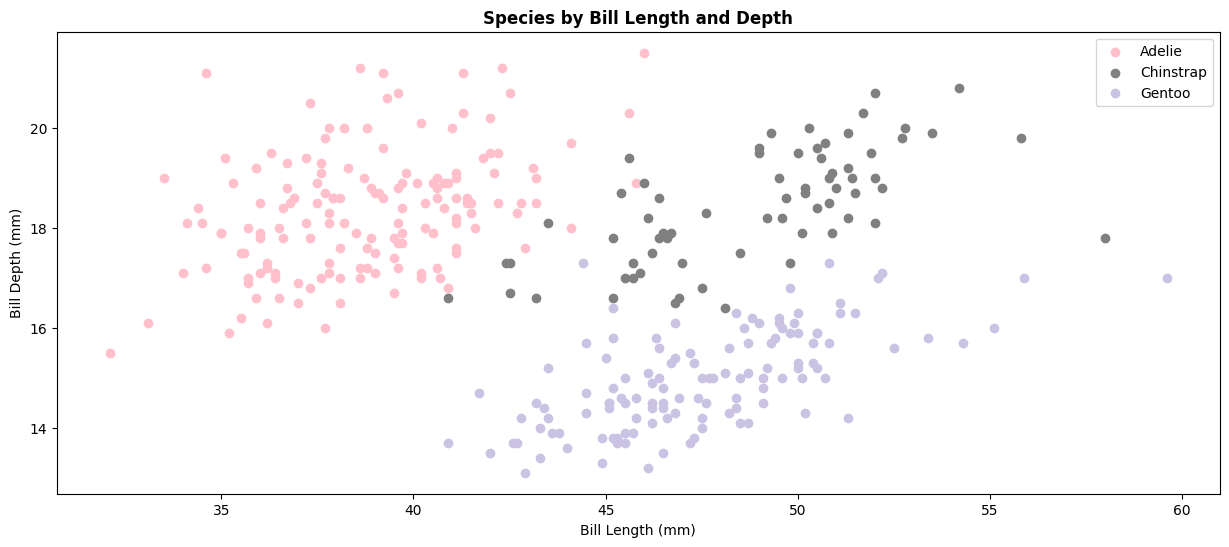

In [31]:
# Plotting bill length and bill depth, color-coded by species
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}

plt.figure(figsize = (15, 6))
for species in np.unique(penguin_species):
    mask = (penguin_species == species)
    plt.scatter(penguin_feature_data[mask, 0], penguin_feature_data[mask, 1], label = species, color = colors[species])
    
plt.legend(['Adelie', 'Chinstrap', 'Gentoo'])
plt.title("Species by Bill Length and Depth", fontweight = 'bold')
plt.xlabel("Bill Length (mm)")
plt.ylabel("Bill Depth (mm)")

plt.show()

Three fairly distinct clusters corresponding to different species appear in the plot. Gentoo penguins tend to have a smaller bill depth and medium to large bill length, chinstrap penguins tend to have a larger bill depth and bill length, and Adelie penguins tend to have a larger bill depth but smaller bill length. The distribution of this data and the presence of visible clusters suggest that it is good candidate for evaluating the custom KNN model.

### KNN Implementation (2 Features)
*Classification using KNN with two features*

This section implements the custom KNN class to classify penguin species based on bill depth and bill length. It carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the KNN model, we normalize the feature data using z-scores for each feature, calculated using the `preprocessing` package. Because KNN is primarily a distance-based algorithm, it is relatively sensitive to scale, and a feature with larger numerical values will contribute more to the weight calculations. Feature normalization is thus a necessary step in the implementation, as it rescales each feature to prevent skewing results based on feature magnitude and ensures that no one feature overly contributes to model predictions.

In [32]:
# Standardizing the features
penguin_feature_data_normal = z_score_standardize(penguin_feature_data[:, [0, 1]])
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874  0.78544923]
 [-0.81112573  0.1261879 ]
 [-0.66437972  0.43046236]
 [-1.32473679  1.08972369]
 [-0.84781224  1.74898502]]


Once the data has been scaled, it is split into testing and training arrays. This ensures that the model is not trained and tested on the same set of data, allowing for unbiased evaluation of model performance and preventing overfitting. The data is split in a 70/30 proportion such that the training data is 70% of the total dataset, and the testing data 30%. There are 342 samples in the cleaned dataset, so the training array should have approximately 240 samples and the testing should have 102.

Because this is a classification problem where the classes may not be evenly represented within the data, stratification is used to split the testing and training sets. Stratification is a division method that first groups the data based on a given label, then randomly samples from each group to ensure that they are proportionally represented in both the testing and training data. This method prevents significant bias arising from disproportionate class counts by preserving relative distributions and ensuring that each class is represented in the training data. In this case, the stratification method is based on the target (*species*), which should guarantee that samples from each species are present in each set.

In [33]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, penguin_species, stratify = penguin_species, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (240, 2)
Shape of training targets: (240,)
Shape of testing array: (102, 2)
Shape of testing targets: (102,)


We now perform classification using KNN by creating an instance of the `knn_classification` class from the supervised learning package, and fitting it on the training data. The previously unseen test data is then provided to the fitted model to predict the species labels. 

This KNN model has the following specifications:
- **k:** 3
- **Distance Metric:** Euclidean
- **Weight:** uniform

In [34]:
# Fitting the model
knn = knn_classification()
knn.fit(train_array, train_targets)

# Predicting species based on testing data
prediction = knn.prediction(test_array)

When the model has been successfully fitted and returns the species predictions for the test data, we evaluate its performance using a variety of visualization and scoring methods. These include plotting the predictions, displaying the overall confusion matrix, and calculating accuracy, precision, recall, and F1 scores for each class. For a description of these metrics, see this [README](README.md).

The plot below is a visualization of the KNN accuracy on the test data. The leftmost subplot displays the overall distribution of bill length and width, color-coded for species; pale points are all data, and darker points indicate the gold-standard species labels for the test dataset. The rightmost subplot displays the same data, but with points that have been incorrectly classified by the KNN model in yellow.

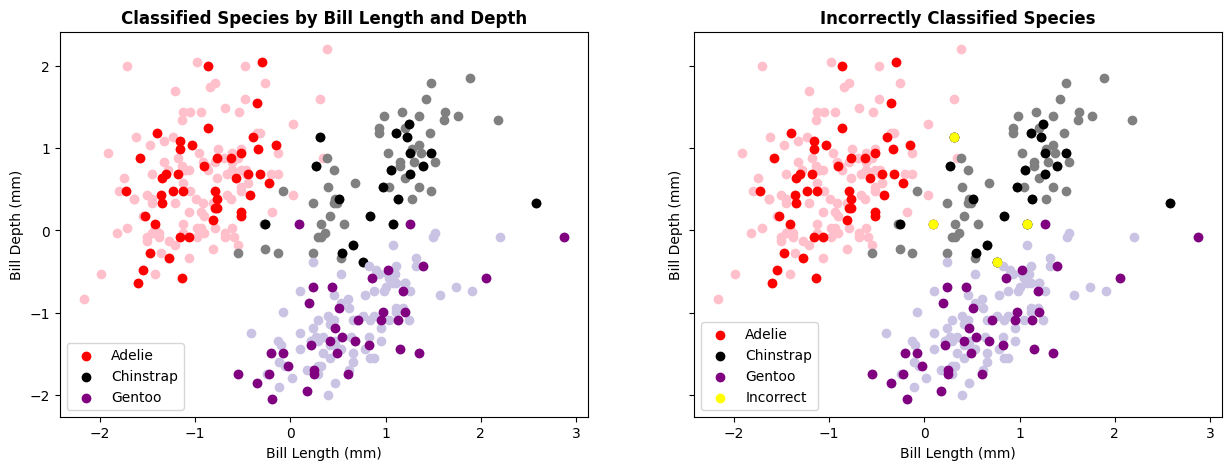

In [35]:
# Plotting bill length and bill depth, color-coded by species
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}
colors_2 = {0: 'red', 1: 'black', 2: 'purple'}

fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharex = True, sharey = True)

for species in np.unique(penguin_species):
    mask = (penguin_species == species)
    ax[0].scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = species, color = colors[species])
    ax[1].scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = species, color = colors[species])
    mask_new = (test_targets == species)
    ax[0].scatter(test_array[mask_new, 0], test_array[mask_new, 1], label = species, color = colors_2[species])
    ax[1].scatter(test_array[mask_new, 0], test_array[mask_new, 1], label = species, color = colors_2[species])

mask_incorrect = (test_targets != prediction)
ax[1].scatter(test_array[mask_incorrect, 0], test_array[mask_incorrect, 1], label = species, color = 'yellow')

handles, labels = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in [1, 3, 5]]
selected_handles_2 = [handles[i] for i in [1, 3, 5, 6]]
ax[0].legend(handles = selected_handles, labels = ['Adelie', 'Chinstrap', 'Gentoo'])
ax[1].legend(handles = selected_handles_2, labels = ['Adelie', 'Chinstrap', 'Gentoo', 'Incorrect'])

ax[0].set_title("Classified Species by Bill Length and Depth", fontweight = 'bold')
ax[1].set_title("Incorrectly Classified Species", fontweight = 'bold')

for i in range(2):
    ax[i].set_xlabel("Bill Length (mm)")
    ax[i].set_ylabel("Bill Depth (mm)")

plt.show()

The custom KNN has good accuracy for species classification, with only several points labeled incorrectly that tend to fall in the overlap between clusters. For a more quantitative evaluation of the model, we plot the confusion matrix for each class, and produce the numerical evaluation metrics (accuracy, recall, precision, and F1 on the micro and macro scale).

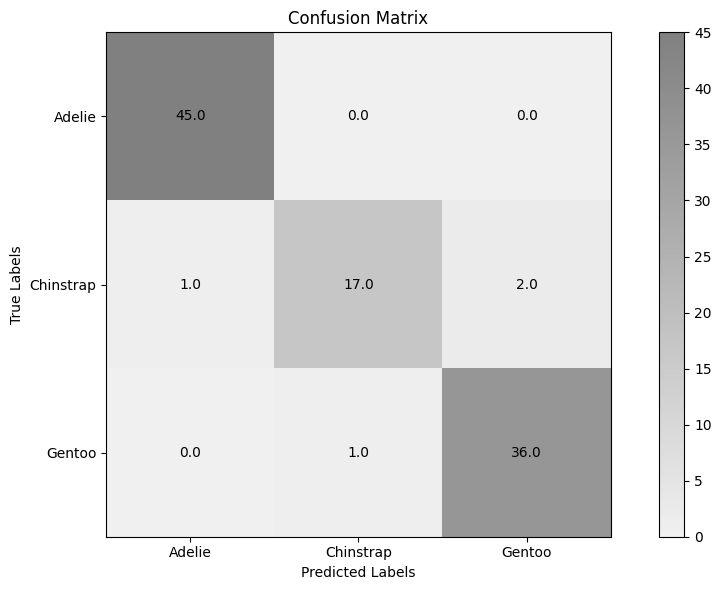

In [36]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(prediction, test_targets, conf_matrix_labels = ['Adelie', 'Chinstrap', 'Gentoo'])

In [37]:
# Evaluating model performance on various metrics
print_model_metrics(prediction, test_targets)

Model Metrics 
------------- 
Accuracy: 0.96 
Precision (Micro): 0.96 
Precision (Macro): 0.96 
Recall (Micro): 0.96 
Recall (Macro): 0.94 
F1 (Micro): 0.96 
F1 (Macro): 0.95


The results of the confusion matrix and evaluation metrics indicate that this KNN model is successful in predicting species from bill length and bill width. The accuracy, precision, recall, and F1 scores are generally all greater than 0.90, and very few incorrect predictions are apparent in the confusion matrix. Together, this validates the use of the custom KNN for a two-feature, multi-class problem.

### KNN Implementation (Changing Parameters)
*Altering k, distance, and weighting parameters*

This section implements the custom KNN for classifying species based on bill length and bill width, but systematically changes a parameter in the model to determine the effects on performance. It first evaluates the model for different values of *k*, using accuracy as the primary metric.

In [38]:
# Arrays for k-values and accuracy
k_values = np.arange(1, 16)
accuracy_values_k = np.full(len(k_values), np.nan)

# Fitting and scoring the model for each value of k
for i in range(len(k_values)):
    knn = knn_classification(k = k_values[i])
    knn.fit(train_array, train_targets)
    accuracy = knn.scoring(test_array, test_targets)
    accuracy_values_k[i] = accuracy

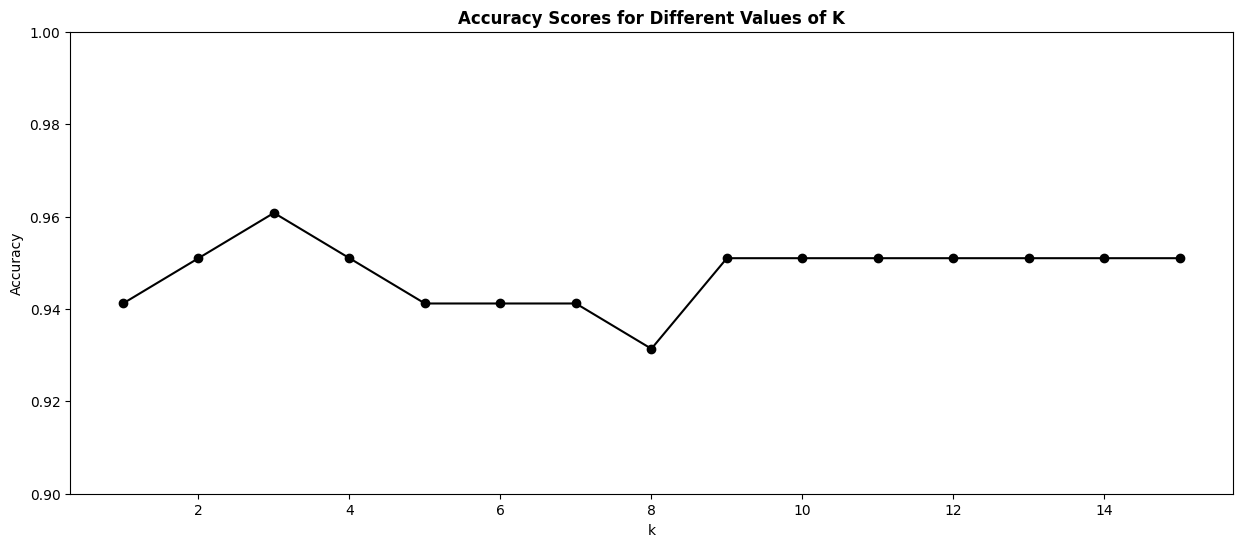

In [39]:
# Plotting the change in accuracy across different k-values
plt.figure(figsize = (15, 6))
plt.plot(k_values, accuracy_values_k, 'black')
plt.scatter(k_values, accuracy_values_k, color = 'black')
plt.title("Accuracy Scores for Different Values of K", fontweight = 'bold')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1)
plt.show()

For larger values of *k*, the accuracy remains fairly constant, indicating that increasing *k* beyond a threshold does not significantly alter model performance. Lower values of *k* (e.g., 1 to 2) produce lower accuracy than slightly higher values (e.g., 3 or 5), which tend to result in the best model performance. Given these results, we will use a k-value of 3 for the remainder of the analysis.

We now evaluate the model for various distance types, using a k-value of 3 and accuracy as the metric.

In [40]:
# Arrays for distance type and accuracy
dist_type = ['euclidean', 'manhattan', 'minkowski', 'minkowski', 'minkowski']
accuracy_values_dist = np.full(5, np.nan)

# Fitting and scoring the model for different distance metrics
for i in range(len(dist_type)):
    knn = knn_classification(k = 3, metric = dist_type[i], p = i + 1)
    knn.fit(train_array, train_targets)
    accuracy = knn.scoring(test_array, test_targets)
    accuracy_values_dist[i] = accuracy

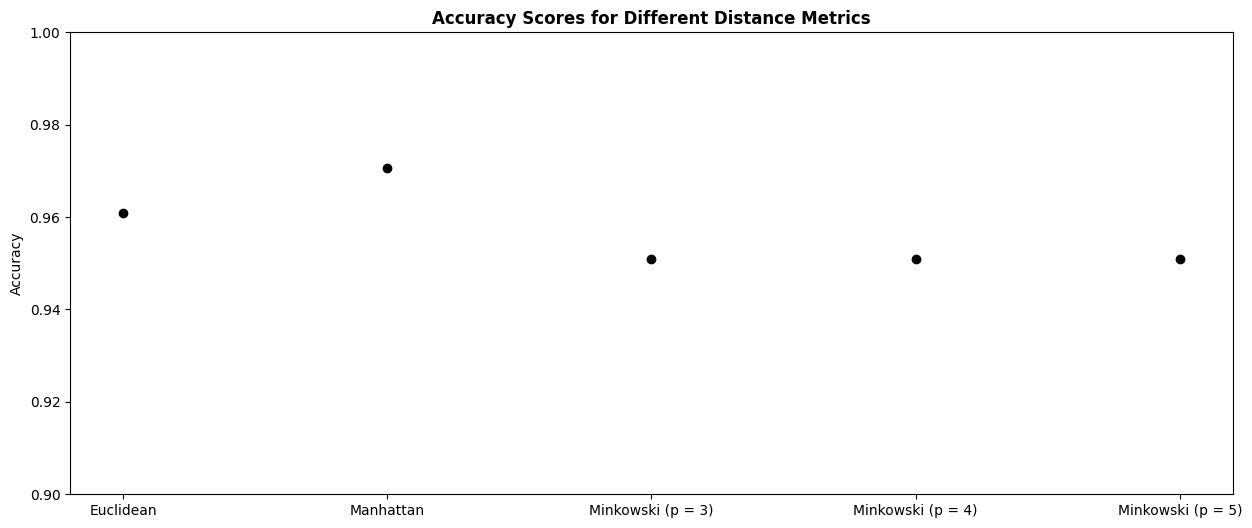

In [41]:
# Plotting the change in accuracy across different k-values
plt.figure(figsize = (15, 6))
plt.scatter(["Euclidean", "Manhattan", "Minkowski (p = 3)", "Minkowski (p = 4)", "Minkowski (p = 5)"], accuracy_values_dist, color = 'black')
plt.title("Accuracy Scores for Different Distance Metrics", fontweight = 'bold')
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.show()

The use of different distance metrics generally does not significantly change model performance for a k-value of 3, as each results in an accuracy score of greater than 0.94 with a variation of around 0.03 to 0.04. Manhattan distance appears to provide the best results for accuracy by a slight margin, but because Euclidean distance is easier to interpret and apply, it will be used for the remainder of the analysis.

Finally, we evaluate model performance using different weighting types (uniform or distance), with accuracy as the metric.

In [42]:
# Arrays for weighting type and accuracy
weights = ['uniform', 'distance']
accuracy_values_weights = np.full(len(weights), np.nan)

# Fitting and scoring the model for different weightings
for i in range(len(weights)):
    knn = knn_classification(k = 3, metric = 'euclidean', weight = weights[i])
    knn.fit(train_array, train_targets)
    accuracy = knn.scoring(test_array, test_targets)
    accuracy_values_weights[i] = accuracy

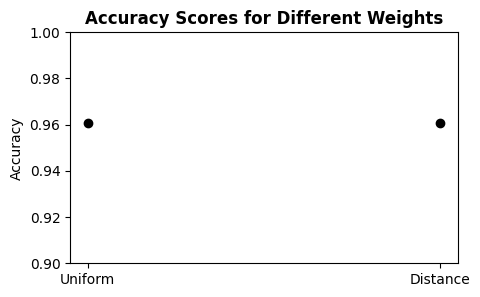

In [43]:
# Plotting the change in accuracy across different weighting types
plt.figure(figsize = (5, 3))
plt.scatter(["Uniform", "Distance"], accuracy_values_weights, color = 'black')
plt.title("Accuracy Scores for Different Weights", fontweight = 'bold')
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.show()

The difference in weighting metrics, which either considers all neighbors equally (*uniform*) or scales their relative importance based on distance from a point (*distance*) does not significantly change the accuracy of the model; it remains at approximately 0.96 regardless of the weighting used. Consequently, a uniform weighting will be applied for the remainder of the analysis.

### KNN Implementation (Multiple Features)
*Classification using KNN with multiple (four) features*

This section implements the custom KNN class to classify penguin species based on bill depth, bill length, flipper length, and body mass. As before, it carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the KNN model, we normalize the feature data using z-scores for each feature, again calculated using the `preprocessing` package. In this case, the entire feature data set (not simply the two selected features) is normalized and used in the KNN analysis. The data is then split into training (70%) and testing arrays (30%) with the stratification method based on species label. Finally, a new instance of the KNN class is created and fit with the training data, then used to classify samples in the testing data.

This KNN model has the following specifications:
- **k:** 3
- **Distance Metric:** Euclidean
- **Weight:** uniform

In [44]:
# Standardizing the features
penguin_feature_data_normal_all_feat = z_score_standardize(penguin_feature_data)
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal_all_feat[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874  0.78544923 -1.41834665 -0.56414208]
 [-0.81112573  0.1261879  -1.06225022 -0.50170305]
 [-0.66437972  0.43046236 -0.42127665 -1.18853234]
 [-1.32473679  1.08972369 -0.56371522 -0.93877623]
 [-0.84781224  1.74898502 -0.77737308 -0.68902013]]


In [45]:
# Splitting the data into training and testing arrays
train_array_mult, test_array_mult, train_targets_mult, test_targets_mult = train_test(penguin_feature_data_normal_all_feat, penguin_species, stratify = penguin_species, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array_mult.shape}")
print(f"Shape of training targets: {train_targets_mult.shape}")
print(f"Shape of testing array: {test_array_mult.shape}")
print(f"Shape of testing targets: {test_targets_mult.shape}")

Shape of training array: (240, 4)
Shape of training targets: (240,)
Shape of testing array: (102, 4)
Shape of testing targets: (102,)


In [46]:
# Fitting the model
knn_mult = knn_classification()
knn_mult.fit(train_array_mult, train_targets_mult)

# Predicting species based on testing data
prediction_mult = knn_mult.prediction(test_array_mult)

Because the model takes in four features, there is no way to easily visualize the resulting classifications, as was possible with two features. Instead, model evaluation is done only using the confusion matrix and various performance metrics.

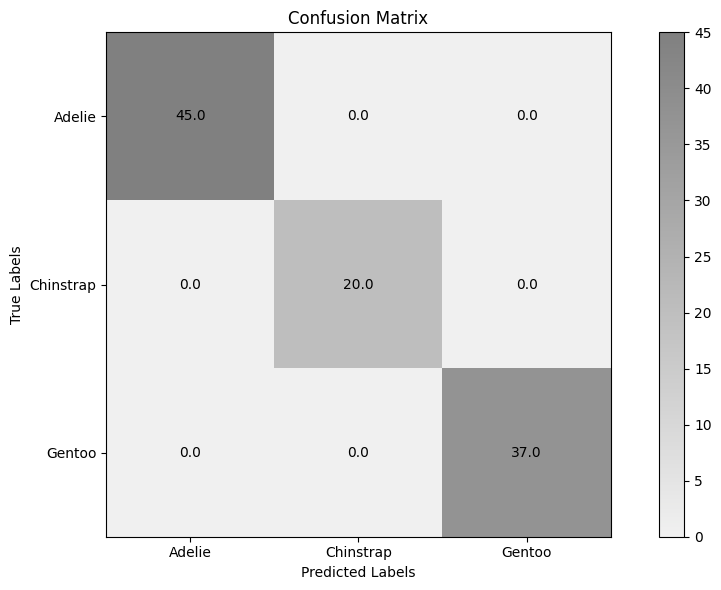

In [47]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(prediction_mult, test_targets_mult, conf_matrix_labels = ['Adelie', 'Chinstrap', 'Gentoo'])

In [48]:
# Evaluating model performance on various metrics
print_model_metrics(prediction_mult, test_targets_mult)

Model Metrics 
------------- 
Accuracy: 1.00 
Precision (Micro): 1.00 
Precision (Macro): 1.00 
Recall (Micro): 1.00 
Recall (Macro): 1.00 
F1 (Micro): 1.00 
F1 (Macro): 1.00


This model has a better accuracy, precision, recall, and F1 score than that containing only two features, suggesting that the inclusion of the additional features has a beneficial effect on model performance. The model accuracy is perfect, and as given in the confusion matrix, no samples have been misclassified. Consequently, the custom KNN has been shown to be reliable and successful in multi-feature classification problems.

### Comparison with Existing Models
*Comparison with scikit-learn KNN*

In order to ensure that the custom-built KNN is functioning as intended and providing expected results, it is useful to compare its performance to a KNN classifier from established code. In this section, we rerun the analysis with all four features using the scikit-learn KNN with a matching number of neighbors (3) and distance metrics (Euclidean) to verify the results of the custom KNN.

In [49]:
# Creating a KNN using scikit-learn
from sklearn.neighbors import KNeighborsClassifier
knn_sk = KNeighborsClassifier(n_neighbors = 3, metric = 'euclidean')
knn_sk.fit(train_array_mult, train_targets_mult)
prediction_sk = knn_sk.predict(test_array_mult)

In [50]:
# Printing the model metrics for the scikit-learn KNN
print_model_metrics(prediction_sk, test_targets_mult)

Model Metrics 
------------- 
Accuracy: 1.00 
Precision (Micro): 1.00 
Precision (Macro): 1.00 
Recall (Micro): 1.00 
Recall (Macro): 1.00 
F1 (Micro): 1.00 
F1 (Macro): 1.00


The scikit-learn KNN classifier has an accuracy, precision, recall, and F1 score that is identical to that of the custom-built KNN. Therefore, the custom `rice_ml` KNN is able to handle multi-class and multi-feature classification problems to a professional standard.